<a href="https://colab.research.google.com/github/devhemza/BERTweet_sentiment_analysis/blob/main/Roberta_vs_BERTweet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
RANDOM_SEED = 1993

In [ ]:
!nvidia-smi

Fri Feb 19 07:55:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
def writeResultsInFile(accuracy, f1_score, random_seed):
    f = open("log_roberta", "a")
    f.write(f'Random seed : {random_seed}, accuracy : {accuracy:.4f}, f1-score : {f1_score:.4f}\n')
    f.close()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cd "/content/drive/MyDrive/TER BERTTweet"

In [ ]:
CUDA_LAUNCH_BLOCKING="1"

In [ ]:
"""
!git clone https://github.com/huggingface/transformers.git
%cd transformers/
!pip3 install --upgrade .
"""

'\n!git clone https://github.com/huggingface/transformers.git\n%cd transformers/\n!pip3 install --upgrade .\n'

In [ ]:
!pip3 install emoji
!pip install transformers sentencepiece

     |████████████████████████████████| 133kB 19.2MB/s 
     |████████████████████████████████| 1.8MB 14.9MB/s 
     |████████████████████████████████| 1.2MB 50.4MB/s 
     |████████████████████████████████| 3.2MB 54.1MB/s 
     |████████████████████████████████| 890kB 46.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=fc242dde8e9c8c054bf12eab2811342498313d7912b75033f57893bd98453f7c
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
#imports hugging face 
from transformers import RobertaTokenizer, RobertaModel



In [ ]:
PRE_TRAINED_MODEL_NAME = "roberta-base"

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
bert_model = RobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
import transformers
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, recall_score, f1_score, accuracy_score, average_precision_score, precision_score
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline


np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class SATweetDataset(Dataset):

  def __init__(self, tweets, targets, tokenizer, max_len):
    self.tweets = tweets
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.tweets)
  
  def __getitem__(self, item):
    tweet = str(self.tweets[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      tweet,
      add_special_tokens=True,
      max_length=self.max_len,
      truncation= True,
      return_token_type_ids=False,
      padding = 'max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'tweet_text': tweet,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):

    ds = SATweetDataset(
        tweets=df.body.to_numpy(),
        targets=df.target.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
    )


In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    #importing the pre_trained model from transformers library
    self.bert = bert_model.from_pretrained(PRE_TRAINED_MODEL_NAME)
    #Adding a linear layer on the top of the bert model
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  #The forward step function
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )
    output = pooled_output
    return self.out(output)

In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer,  device, n_examples):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  tweets_content = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["tweet_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      
      _, preds = torch.max(outputs, dim=1)
      
      probs = nn.functional.softmax(outputs, dim=1)

      tweets_content.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return tweets_content, predictions, prediction_probs, real_values

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

In [ ]:
def avg_rec(y_test, y_pred):
    rec_n, rec_u, rec_p = recall_score(y_test, y_pred, average=None)
    return (1/3) * (rec_n+ rec_u+ rec_p)


In [ ]:
def f1_np(y_test, y_pred):
    f1_p, _,f1_n = f1_score(y_test, y_pred, average=None)
    return 0.5*(f1_n+f1_p)

####SemEval-2018Task3A

In [ ]:
%ls

acc_score.jpg
bertweet_best_model_state.bin
bertweet_preds.csv
best_model_state.bin
best_model_state_random_state_11.bin
best_model_state_random_state_1993.bin
best_model_state_random_state_22.bin
best_model_state_random_state_7.bin
f1score.jpg
goldtest_TaskA/
goldtest_TaskB/
log
log_bert
log_roberta
README.md
roberta_bad_pred.csv
Roberta_best_model_state.bin
Roberta_best_model_state_random_state_11.bin
Roberta_best_model_state_random_state_1993.bin
Roberta_best_model_state_random_state_22.bin
Roberta_best_model_state_random_state_7.bin
test_TaskA/
test_TaskB/
train/
transformers/
trial/


In [ ]:
%cd '/content/drive/MyDrive/TER BERTTweet/SemEval-2018Task3A/datasets'

/content/drive/MyDrive/TER BERTTweet/SemEval-2018Task3A/datasets


In [ ]:
df_semEval18_train = pd.read_csv('train/SemEval2018-T3-train-taskA_emoji.txt', skiprows=[0], names = ['id', 'target', 'body'], sep = "\t")
df_semEval18_test = pd.read_csv('goldtest_TaskA/SemEval2018-T3_gold_test_taskA_emoji.txt', skiprows=[0], names = ['id', 'target', 'body'], sep = "\t")
df_semEval18_train

,id,target,body
0,1,1,Sweet United Nations video. Just in time for C...
1,2,1,@mrdahl87 We are rumored to have talked to Erv...
2,3,1,Hey there! Nice to see you Minnesota/ND Winter...
3,4,0,3 episodes left I'm dying over here
4,5,1,I can't breathe! was chosen as the most notabl...
...,...,...,...
3812,3830,0,@banditelli regarding what the PSU president does
3813,3831,0,@banditelli But still bothers me that I see no...
3814,3832,0,well now that i've listened to all of into the...
3815,3833,0,Hummingbirds #Are #Experts #at #Hovering #Aft...


In [ ]:
df_semEval18_train[df_semEval18_train["target"] == 0]

,id,target,body
3,4,0,3 episodes left I'm dying over here
5,6,0,You're never too old for Footie Pajamas. http:...
7,8,0,4:30 an opening my first beer now gonna be a l...
8,9,0,@Adam_Klug do you think you would support a gu...
9,10,0,@samcguigan544 You are not allowed to open tha...
...,...,...,...
3812,3830,0,@banditelli regarding what the PSU president does
3813,3831,0,@banditelli But still bothers me that I see no...
3814,3832,0,well now that i've listened to all of into the...
3815,3833,0,Hummingbirds #Are #Experts #at #Hovering #Aft...


In [ ]:
df_semEval18_train['target'] = df_semEval18_train['target'].astype(int)

In [ ]:
df_semEval18_test['target'] = df_semEval18_test['target'].astype(int)

In [ ]:
token_lens = []
for txt in df_semEval18_train.body:
  tokens = tokenizer.encode(txt, max_length=128)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


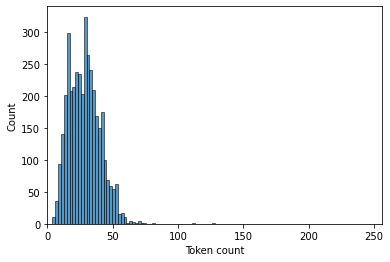

In [ ]:
sns.histplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [ ]:
MAX_LEN = max(token_lens)
BATCH_SIZE = 32

In [ ]:
MAX_LEN

128

In [ ]:

df_train, df_val = train_test_split(df_semEval18_train, test_size=0.1, random_state=RANDOM_SEED)
df_test = df_semEval18_test

In [ ]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
data = next(iter(val_data_loader))
data.keys()

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
n_classes = 2
class_names = ['ironic', 'non-ironic']

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([32, 128])
torch.Size([32, 128])


In [ ]:
model = SentimentClassifier(n_classes)
model = model.to(device)

In [ ]:
EPOCHS = 30

optimizer = optim.AdamW(model.parameters(), lr=1e-5)
total_steps = len(train_data_loader) * EPOCHS
"""
scheduler = transformers.get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
"""
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0
early_stop = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), f'Roberta_best_model_state_random_state_{RANDOM_SEED}.bin')
    best_accuracy = val_acc
    early_stop = 0
  else:
      early_stop = early_stop + 1
      if early_stop == 5:
        break

Epoch 1/30
----------


KeyboardInterrupt: ignored

In [ ]:
model.load_state_dict(torch.load(f'Roberta_best_model_state_random_state_{RANDOM_SEED}.bin'))

<All keys matched successfully>

In [ ]:
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.6071428571428571

In [ ]:
y_tweet_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

      ironic       0.61      0.99      0.75       473
  non-ironic       0.60      0.03      0.06       311

    accuracy                           0.61       784
   macro avg       0.60      0.51      0.40       784
weighted avg       0.60      0.61      0.48       784



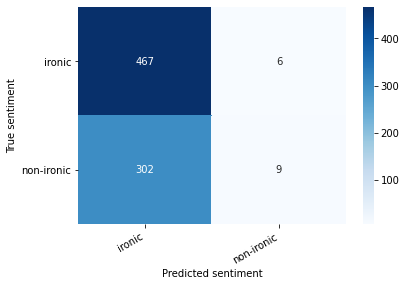

In [ ]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
accuracy_score(y_test, y_pred)

0.6071428571428571

In [ ]:
f1_p,_ = f1_score(y_test, y_pred, average=None)

In [ ]:
print(f1_p)

0.7520128824476651


In [ ]:
f1_score(y_test, y_pred, average="weighted")

0.4756044292587371

In [ ]:
writeResultsInFile(accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted'), random_seed=RANDOM_SEED)

In [ ]:
df_test["y_pred"] = y_pred

In [ ]:
df_compare = df_test[df_test['target'] != df_test['y_pred']]

In [ ]:
df_compare.to_csv('roberta_bad_pred.csv', sep="\t")

# SemEval 2019 TASK 5

In [ ]:
%cd '/content/drive/MyDrive/TER BERTTweet/SemEval2019Task5/datasets'

In [ ]:
!ls

In [ ]:
df_semEval19_train = pd.read_csv('hateval2019_en_train.csv', sep = ",")
#df_semEval19_train_val = pd.read_csv('hateval2019_en_dev.csv', sep = "\t")
df_semEval19_valid = pd.read_csv('hateval2019_en_dev.csv',  sep = ",")
df_test_gold = pd.read_csv('hateval2019_en_test.csv', sep = ",")
#df_result = pd.read_csv('en_a.tsv', sep = "\t", names=["id", "target"])
#df_test_gold = pd.concat([df_semEval19_test, df_result.target], axis=1)

In [ ]:
df_test_gold

,id,text,HS,TR,AG
0,34243,"@local1025 @njdotcom @GovMurphy Oh, I could ha...",0,0,0
1,30593,Several of the wild fires in #california and #...,0,0,0
2,31427,@JudicialWatch My question is how do you reset...,0,0,0
3,31694,"#Europe, you've got a problem! We must hurry...",1,0,0
4,31865,This is outrageous! #StopIllegalImmigration #...,1,0,0
...,...,...,...,...,...
2995,31368,you can never take a L off a real bitch😩 im ho...,1,1,0
2996,30104,@Brian_202 likes to call me a cunt & a bitch b...,1,1,0
2997,31912,@kusha1a @Camio_the_wise @shoe0nhead 1. Never ...,1,1,0
2998,31000,If i see and know you a hoe why would i hit yo...,1,1,0


In [ ]:
df_train = df_semEval19_train.drop(columns=['TR', 'AG']).rename(columns = {"text" : "body", "HS" : "target"})
#df_train_val = df_semEval19_train_val.drop(columns=['TR', 'AG']).rename(columns = {"text" : "body", "HS" : "target"})
df_val = df_semEval19_valid.drop(columns=['TR', 'AG']).rename(columns = {"text" : "body", "HS" : "target"})
df_test = df_test_gold.drop(columns=['TR', 'AG']).rename(columns = {"text" : "body", "HS" : "target"})

In [ ]:
df_train

,id,body,target
0,201,"Hurray, saving us $$$ in so many ways @potus @...",1
1,202,Why would young fighting age men be the vast m...,1
2,203,@KamalaHarris Illegals Dump their Kids at the ...,1
3,204,NY Times: 'Nearly All White' States Pose 'an A...,0
4,205,Orban in Brussels: European leaders are ignori...,0
...,...,...,...
8995,9196,@mmdwriter @JRubinBlogger @BenSasse I am proud...,0
8996,9197,@CheriJacobus Hollywood is complicit in the ra...,0
8997,9198,@amaziah_filani What a fucking cunt I hate see...,1
8998,9199,Hysterical woman like @CoryBooker,0


In [ ]:
df_train_val = pd.concat([df_train, df_val], axis = 0)
df_train_val

,id,body,target
0,201,"Hurray, saving us $$$ in so many ways @potus @...",1
1,202,Why would young fighting age men be the vast m...,1
2,203,@KamalaHarris Illegals Dump their Kids at the ...,1
3,204,NY Times: 'Nearly All White' States Pose 'an A...,0
4,205,Orban in Brussels: European leaders are ignori...,0
...,...,...,...
995,19196,@SamEnvers you unfollowed me? Fuck you pussy,0
996,19197,@DanReynolds STFU BITCH! AND YOU GO MAKE SOME ...,1
997,19198,"@2beornotbeing Honey, as a fellow white chick,...",0
998,19199,I hate bitches who talk about niggaz with kids...,1


In [ ]:
df_train, df_val = train_test_split(df_train_val, test_size=0.1, random_state=RANDOM_SEED)

In [ ]:
token_lens = []
for txt in df_train.body:
  tokens = tokenizer.encode(txt, max_length=128)
  token_lens.append(len(tokens))

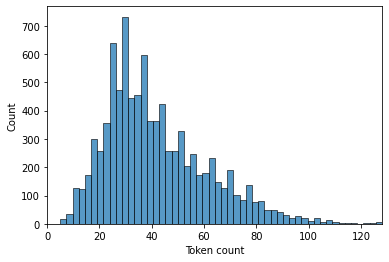

In [ ]:
sns.histplot(token_lens)
plt.xlim([0, 128]);
plt.xlabel('Token count');

In [ ]:
MAX_LEN = np.max(token_lens)
BATCH_SIZE = 32

In [ ]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
data = next(iter(val_data_loader))
data.keys()

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
n_classes = 2
class_names = ['hateful', 'non-hateful']

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([32, 128])
torch.Size([32, 128])


In [ ]:
model = SentimentClassifier(n_classes)
model = model.to(device)

In [ ]:
EPOCHS = 30

optimizer = optim.AdamW(model.parameters(), lr=1e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = transformers.get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0
early_stop = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'Roberta_best_model_state.bin')
    best_accuracy = val_acc
    early_stop = 0
  else:
      early_stop = early_stop + 1
      if early_stop == 5:
        break

Epoch 1/30
----------
Train loss 0.4885054440997171 accuracy 0.7485555555555556
Val   loss 0.4201112696900964 accuracy 0.807

Epoch 2/30
----------
Train loss 0.35055041537745624 accuracy 0.8424444444444444
Val   loss 0.39465188048779964 accuracy 0.833

Epoch 3/30
----------
Train loss 0.28478172915518707 accuracy 0.8788888888888889
Val   loss 0.4091146308928728 accuracy 0.835

Epoch 4/30
----------
Train loss 0.22135696453141404 accuracy 0.909888888888889
Val   loss 0.4900568728335202 accuracy 0.848

Epoch 5/30
----------
Train loss 0.1676669703674311 accuracy 0.9363333333333334
Val   loss 0.5672094575129449 accuracy 0.834

Epoch 6/30
----------
Train loss 0.12440408787901468 accuracy 0.9523333333333334
Val   loss 0.6148598506115377 accuracy 0.8260000000000001

Epoch 7/30
----------
Train loss 0.11931660821568882 accuracy 0.9566666666666667
Val   loss 0.6488204165361822 accuracy 0.8250000000000001

Epoch 8/30
----------
Train loss 0.09337399971542602 accuracy 0.9663333333333334
Val   

In [ ]:

model.load_state_dict(torch.load('Roberta_best_model_state.bin'))

<All keys matched successfully>

In [ ]:
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.5503333333333333

In [ ]:
y_tweet_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

     hateful       0.91      0.25      0.39      1740
 non-hateful       0.48      0.97      0.64      1260

    accuracy                           0.55      3000
   macro avg       0.70      0.61      0.52      3000
weighted avg       0.73      0.55      0.50      3000



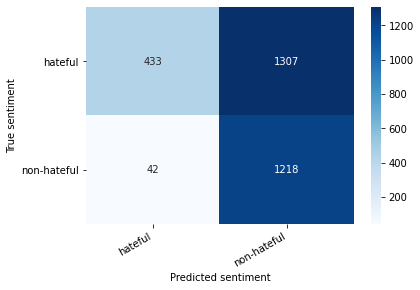

In [ ]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
accuracy_score(y_test, y_pred)

0.5503333333333333

In [ ]:
f1_score(y_test, y_pred)

0.6435931307793923

In [ ]:
writeResultsInFile(accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted'), random_seed=RANDOM_SEED)

# SemEval 2016 Task 6

In [ ]:
%cd "/content/drive/MyDrive/TER BERTTweet/SemEval2016Task6"

/content/drive/.shortcut-targets-by-id/17CE24Rj2KkFXfKV0IKGKdgQ9DW8PLJeH/TER BERTTweet/SemEval2016Task6


In [ ]:
!ls -l

total 910753
-rw------- 1 root root 433338016 Jan 30 12:22 best_model_state.bin
-rw------- 1 root root       234 Jan 29 08:45 log
-rw------- 1 root root        78 Jan 30 12:25 log_bert
-rw------- 1 root root        77 Jan 30 12:18 log_roberta
-rw------- 1 root root 498679457 Jan 30 12:15 Roberta_best_model_state.bin
-rw------- 1 root root    179446 Jan 29 06:26 test_gold.txt
-rw------- 1 root root    397092 Jan 29 06:26 train.txt
-rw------- 1 root root     13911 Jan 29 06:28 trial.txt


In [ ]:
df_sem16train = pd.read_csv("train.txt", sep="\t", encoding = "ISO-8859-1")
df_sem16val = pd.read_csv("trial.txt", sep="\t", encoding = "ISO-8859-1")
df_sem16test = pd.read_csv("test_gold.txt", sep="\t", encoding = "ISO-8859-1")

In [ ]:
df_sem16train["Stance"].unique()

array(['AGAINST', 'FAVOR', 'NONE'], dtype=object)

In [ ]:
df_sem16train["Target"].unique()

array(['Atheism', 'Climate Change is a Real Concern', 'Feminist Movement',
       'Hillary Clinton', 'Legalization of Abortion'], dtype=object)

In [ ]:
df_sem16train["Target"] = df_sem16train["Target"].astype('category')
df_sem16train['target'] = df_sem16train['Target'].cat.codes

In [ ]:
df_train = df_sem16train[["Tweet", "Stance"]]
df_val = df_sem16val[["Tweet", "Stance"]]

In [ ]:
df_train = df_val.append(df_train)

In [ ]:
df_train

,Tweet,Stance
0,"@tedcruz And, #HandOverTheServer she wiped cle...",AGAINST
1,Hillary is our best choice if we truly want to...,FAVOR
2,@TheView I think our country is ready for a fe...,AGAINST
3,I just gave an unhealthy amount of my hard-ear...,AGAINST
4,@PortiaABoulger Thank you for adding me to you...,NONE
...,...,...
2809,"There's a law protecting unborn eagles, but no...",AGAINST
2810,I am 1 in 3... I have had an abortion #Abortio...,AGAINST
2811,How dare you say my sexual preference is a cho...,AGAINST
2812,"Equal rights for those 'born that way', no rig...",AGAINST


In [ ]:
df_val

,Tweet,Stance
0,"@tedcruz And, #HandOverTheServer she wiped cle...",AGAINST
1,Hillary is our best choice if we truly want to...,FAVOR
2,@TheView I think our country is ready for a fe...,AGAINST
3,I just gave an unhealthy amount of my hard-ear...,AGAINST
4,@PortiaABoulger Thank you for adding me to you...,NONE
...,...,...
95,@Corey_Frizzell @PEILiberalParty and most Isla...,NONE
96,@Docjp Pressure? It's their job and they are f...,NONE
97,I love how #liberals only accuse #conservative...,AGAINST
98,Help your friend figure out how they're going ...,NONE


In [ ]:
def sentiment_encode(sentiment):
  if sentiment == 'AGAINST':
    return 0
  elif sentiment == 'NONE':
    return 1
  else: 
    return 2

In [ ]:
df_train['target'] = df_train.Stance.apply(sentiment_encode)

In [ ]:
class_names = ['negative', 'neutral', 'positive']

In [ ]:
df_train = df_train.rename(columns={'Tweet' : 'body'});

In [ ]:
df_test = df_sem16test
df_test['target'] = df_test.Stance.apply(sentiment_encode)
df_test = df_test.rename(columns={'Tweet' : 'body'});

In [ ]:
df_train, df_val = train_test_split(df_train, test_size=0.1, random_state=RANDOM_SEED)

In [ ]:
df_train

,body,Stance,target
340,@_kissmysassyass and you don't support equalit...,NONE,1
2122,"@sunbeltgirl @9975Ts @bobwilsonn ""@HillaryClin...",AGAINST,0
1357,They don't call it MALE-volent for no reason #...,FAVOR,2
1298,Those fucking feminists... Sir Tim Hunt was ...,AGAINST,0
771,As the world emitted CO2 water vapour built up...,FAVOR,2
...,...,...,...
1503,How to spot a fashion-#Feminist - they claim f...,AGAINST,0
2450,"@ProLifeYouth Precisely! In God's eyes, ALL li...",AGAINST,0
437,The most important thing in this world with me...,AGAINST,0
1120,"Eating a bagel by myself rocking out to ""Man! ...",FAVOR,2


In [ ]:
token_lens = []
for txt in df_train.body:
  tokens = tokenizer.encode(txt, max_length=128)
  token_lens.append(len(tokens))

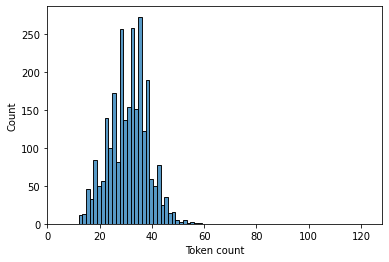

In [ ]:
sns.histplot(token_lens)
plt.xlim([0, 128]);
plt.xlabel('Token count');

In [ ]:
MAX_LEN = np.max(token_lens)
BATCH_SIZE = 32

In [ ]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
data = next(iter(val_data_loader))
data.keys()

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
n_classes = 3
class_names = ['postive', 'negative', 'neutral']

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([32, 59])
torch.Size([32, 59])


In [ ]:
model = SentimentClassifier(n_classes)
model = model.to(device)

In [ ]:
EPOCHS = 30

optimizer = optim.AdamW(model.parameters(), lr=1e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = transformers.get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0
early_stop = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'Roberta_best_model_state.bin')
    best_accuracy = val_acc
    early_stop = 0
  else:
      early_stop = early_stop + 1
      if early_stop == 5:
        break

Epoch 1/30
----------
Train loss 1.0109079996260202 accuracy 0.5049580472921434
Val   loss 0.8718448460102082 accuracy 0.613013698630137

Epoch 2/30
----------
Train loss 0.7594416443167663 accuracy 0.6765827612509535
Val   loss 0.763882401585579 accuracy 0.6883561643835616

Epoch 3/30
----------
Train loss 0.6092486992114927 accuracy 0.7479023646071702
Val   loss 0.7361257612705231 accuracy 0.6986301369863013

Epoch 4/30
----------
Train loss 0.4864179800923278 accuracy 0.8039664378337148
Val   loss 0.8192168414592743 accuracy 0.7020547945205479

Epoch 5/30
----------
Train loss 0.3911612437265675 accuracy 0.8466819221967964
Val   loss 0.768397331237793 accuracy 0.726027397260274

Epoch 6/30
----------
Train loss 0.3358078484491604 accuracy 0.8745232646834478
Val   loss 0.8039110034704209 accuracy 0.7123287671232876

Epoch 7/30
----------
Train loss 0.22783776586193863 accuracy 0.912280701754386
Val   loss 0.9691499173641205 accuracy 0.6986301369863013

Epoch 8/30
----------
Train los

In [ ]:

model.load_state_dict(torch.load('Roberta_best_model_state.bin'))

In [ ]:
df_sem16test

In [ ]:
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

In [ ]:
y_tweet_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
f1_score(y_test, y_pred, average='weighted')

In [ ]:
writeResultsInFile(accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted'), random_seed=RANDOM_SEED)

# SemEval2020Task9

In [ ]:
%cd "/content/drive/MyDrive/TER BERTTweet/SemEval2020Task9"

/content/drive/MyDrive/TER BERTTweet/SemEval2020Task9


In [ ]:
!ls

best_model_state.bin			 Roberta_best_model_state.bin
dev_3k_split_conll.txt			 Spanglish
FinalTest.tsv.txt			 test_labels_hinglish.txt
Hindi_test_unalbelled_conll_updated.txt  train_14k_split_conll.txt
Hinglish				 TrainV1.tsv.txt
log					 Ty.txt
log_roberta				 ValidationV1.tsv.txt


In [ ]:
 df_train = pd.read_csv("TrainV1.tsv.txt", sep="\t", header=None,  names=['id', 'body', 'target'])
df_val = pd.read_csv("ValidationV1.tsv.txt", sep="\t", header=None,  names=['id', 'body', 'target'])
df_test = pd.read_csv("FinalTest.tsv.txt", sep="\t", header=None,  names=['id', 'body'])
df_ytest = pd.read_csv("test_labels_hinglish.txt", sep=",", header=0, names=['id', 'sentiment'])

In [ ]:
df_train = df_val.append(df_train)

In [ ]:
df_test = df_test.merge(df_ytest)

In [ ]:
df_train, df_val = train_test_split(df_train, test_size=0.1, random_state=RANDOM_SEED)

In [ ]:
df_train = df_train.dropna()

In [ ]:
df_train['target'].unique()

array([1, 0, 2])

In [ ]:
token_lens = []
for txt in df_train.body:
  tokens = tokenizer.encode(txt, max_length=128)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


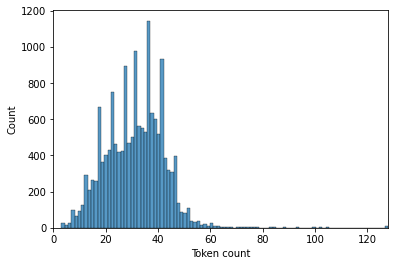

In [ ]:
sns.histplot(token_lens)
plt.xlim([0, 128]);
plt.xlabel('Token count');

In [ ]:
MAX_LEN = np.max(token_lens)
BATCH_SIZE = 32

In [ ]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
data = next(iter(val_data_loader))
data.keys()

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
n_classes = 3
class_names = ['postive', 'neutral', 'negative']

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([32, 128])
torch.Size([32, 128])


In [ ]:
model = SentimentClassifier(n_classes)
model = model.to(device)

In [ ]:
EPOCHS = 30

optimizer = optim.AdamW(model.parameters(), lr=1e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = transformers.get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0
early_stop = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'Roberta_best_model_state.bin')
    best_accuracy = val_acc
    early_stop = 0
  else:
      early_stop = early_stop + 1
      if early_stop == 5:
        break

Epoch 1/30
----------
Train loss 0.9205198172969048 accuracy 0.5341893857929028
Val   loss 0.9210813143036582 accuracy 0.5857954545454546

Epoch 2/30
----------
Train loss 0.8147069899722783 accuracy 0.6169903219684989
Val   loss 0.8720517505298961 accuracy 0.6096590909090909

Epoch 3/30
----------
Train loss 0.7435069174929099 accuracy 0.6625339996204693
Val   loss 0.8729490150104869 accuracy 0.6272727272727272

Epoch 4/30
----------
Train loss 0.6792015922641513 accuracy 0.7024479726737933
Val   loss 0.8955309954556552 accuracy 0.6414772727272727

Epoch 5/30
----------
Train loss 0.6133649268610911 accuracy 0.7377443228540704
Val   loss 0.9262065546079116 accuracy 0.6363636363636364

Epoch 6/30
----------
Train loss 0.546982999134696 accuracy 0.7750648364855461
Val   loss 0.985301440412348 accuracy 0.65625

Epoch 7/30
----------


In [ ]:

model.load_state_dict(torch.load('Roberta_best_model_state.bin'))

In [ ]:
def sentiment_encode(sentiment):
  if sentiment == 'negative':
    return 0
  elif sentiment == 'neutral':
    return 1
  else: 
    return 2

In [ ]:
df_test['target'] = df_test.sentiment.apply(sentiment_encode)

In [ ]:
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

In [ ]:
y_tweet_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
f1_score(y_test, y_pred, average='weighted')

In [ ]:
writeResultsInFile(accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted'), random_seed=RANDOM_SEED)

# SemEval 2019 task 6


In [ ]:
%cd /content/drive/MyDrive/TER BERTTweet/SemEval2019Task6

/content/drive/MyDrive/TER BERTTweet/SemEval2019Task6


In [ ]:
!ls

best_model_state.bin  log_roberta		    testset-levela.tsv
labels-levela.csv     olid-annotation.txt	    testset-levelb.tsv
labels-levelb.csv     olid-training-v1.0.tsv	    testset-levelc.tsv
labels-levelc.csv     README.txt
log		      Roberta_best_model_state.bin


In [ ]:
df_train = pd.read_csv("olid-training-v1.0.tsv", sep="\t", header=0,  names=['id', 'body', 'target', 'dropme', 'dropme2'])
df_test = pd.read_csv("testset-levela.tsv", sep="\t", header=0,  names=['id', 'body'])
df_ytest = pd.read_csv("labels-levela.csv", sep=",", header=0, names=['id', 'sentiment'])

In [ ]:
df_test = df_test.merge(df_ytest)

In [ ]:
df_train

,id,body,target,dropme,dropme2
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN
...,...,...,...,...,...
13235,95338,@USER Sometimes I get strong vibes from people...,OFF,TIN,IND
13236,67210,Benidorm ✅ Creamfields ✅ Maga ✅ Not too sh...,NOT,NaN,NaN
13237,82921,@USER And why report this garbage. We don't g...,OFF,TIN,OTH
13238,27429,@USER Pussy,OFF,UNT,NaN


In [ ]:
df_test

,id,body,sentiment
0,27014,"#ConstitutionDay is revered by Conservatives, ...",NOT
1,30530,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...,NOT
2,13876,#Watching #Boomer getting the news that she is...,NOT
3,60133,#NoPasaran: Unity demo to oppose the far-right...,OFF
4,83681,. . . What the fuck did he do this time?,OFF
...,...,...,...
854,73439,#DespicableDems lie again about rifles. Dem Di...,OFF
855,25657,#MeetTheSpeakers 🙌 @USER will present in our e...,NOT
856,67018,3 people just unfollowed me for talking about ...,OFF
857,50665,#WednesdayWisdom Antifa calls the right fascis...,NOT


In [ ]:
df_train['target'].unique()

array(['OFF', 'NOT'], dtype=object)

In [ ]:
def sentiment_encode(sentiment):
  if sentiment == 'OFF':
    return 0
  elif sentiment == 'NOT':
    return 1

In [ ]:
df_train['target'] = df_train.target.apply(sentiment_encode)

In [ ]:
df_train, df_val = train_test_split(df_train, test_size=0.1, random_state=RANDOM_SEED)

In [ ]:
token_lens = []
for txt in df_train.body:
  tokens = tokenizer.encode(txt, max_length=128)
  token_lens.append(len(tokens))

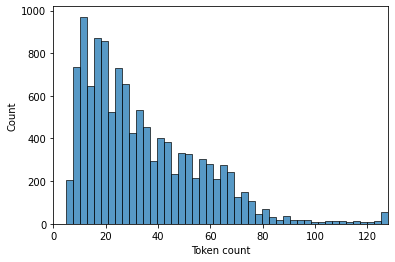

In [ ]:
sns.histplot(token_lens)
plt.xlim([0, 128]);
plt.xlabel('Token count');

In [ ]:
MAX_LEN = np.max(token_lens)
BATCH_SIZE = 32

In [ ]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
data = next(iter(val_data_loader))
data.keys()

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
n_classes = 2
class_names = ['offensive', 'not_offensive']

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([32, 128])
torch.Size([32, 128])


In [ ]:
model = SentimentClassifier(n_classes)
model = model.to(device)

In [ ]:
EPOCHS = 30

optimizer = optim.AdamW(model.parameters(), lr=1e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = transformers.get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0
early_stop = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'Roberta_best_model_state.bin')
    best_accuracy = val_acc
    early_stop = 0
  else:
      early_stop = early_stop + 1
      if early_stop == 5:
        break

Epoch 1/30
----------
Train loss 0.4914900112807271 accuracy 0.7636790869419268
Val   loss 0.4502015078351611 accuracy 0.8021148036253777

Epoch 2/30
----------
Train loss 0.3937348975892361 accuracy 0.8225075528700906
Val   loss 0.48773068260578883 accuracy 0.7870090634441088

Epoch 3/30
----------
Train loss 0.34361851487019107 accuracy 0.8531386371265526
Val   loss 0.5230149995713007 accuracy 0.7817220543806647

Epoch 4/30
----------
Train loss 0.2936758944020674 accuracy 0.8790701577710641
Val   loss 0.5705704994144893 accuracy 0.7779456193353474

Epoch 5/30
----------
Train loss 0.23740394102863907 accuracy 0.9057569654246391
Val   loss 0.6095804135714259 accuracy 0.7892749244712991

Epoch 6/30
----------
Train loss 0.1993692744218672 accuracy 0.9215340718361866
Val   loss 0.7292186376594362 accuracy 0.7507552870090635

CPU times: user 15min 42s, sys: 11min 15s, total: 26min 57s
Wall time: 27min 12s


In [ ]:

model.load_state_dict(torch.load('Roberta_best_model_state.bin'))

<All keys matched successfully>

In [ ]:
df_test['target'] = df_test.sentiment.apply(sentiment_encode)

In [ ]:
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.849825378346915

In [ ]:
y_tweet_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

               precision    recall  f1-score   support

    offensive       0.76      0.67      0.71       239
not_offensive       0.88      0.92      0.90       620

     accuracy                           0.85       859
    macro avg       0.82      0.79      0.80       859
 weighted avg       0.85      0.85      0.85       859



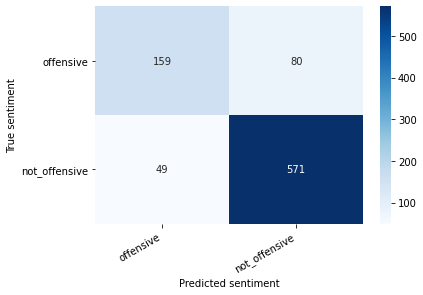

In [ ]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
accuracy_score(y_test, y_pred)

0.8498253783469151

In [ ]:
f1_score(y_test, y_pred, average='weighted')

0.8464493787768231

In [ ]:
writeResultsInFile(accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted'), random_seed=RANDOM_SEED)

# SemEval2017


In [ ]:
%cd '/content/drive/My Drive/TER BERTTweet/SemEval-2017Task4A/Subtask_A'

/content/drive/My Drive/TER BERTTweet/SemEval-2017Task4A/Subtask_A


In [ ]:
df = pd.read_csv('semEvaltaskA_train.txt', sep = ',')

In [ ]:
df_test = pd.DataFrame(columns=['id', 'sentiment', 'body'])
import glob
try:
    for file in glob.glob("SemEval2017-task4-test.subtask-A.english.txt"):
        data = pd.DataFrame(columns=['id', 'sentiment', 'body'])
        for line_id, line in enumerate(open(file, "r", encoding="utf-8").readlines()):
            columns = line.rstrip().split('\t')

            tweet_id = columns[0]
            sentiment = columns[1]
            text = columns[2]
            data = data.append({'id': tweet_id, 'sentiment': sentiment, 'body': text}, ignore_index=True) 
        print(f'{file} ------- {len(data)}')
        df_test = df_test.append(data, ignore_index=True)
except Exception as e:
    print("\nWrong format in line:{} in file:{}".format(line_id, file))
    raise Exception

SemEval2017-task4-test.subtask-A.english.txt ------- 12284


In [ ]:
df_train, df_val = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)

In [ ]:
def sentiment_encode(sentiment):
  if sentiment == 'negative':
    return 0
  elif sentiment == 'neutral':
    return 1
  else: 
    return 2

In [ ]:
df_train['target'] = df_train.sentiment.apply(sentiment_encode)
df_val['target'] = df_val.sentiment.apply(sentiment_encode)
df_test['target'] = df_test.sentiment.apply(sentiment_encode)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df_test['target'] = df_test.sentiment.apply(sentiment_encode)

In [ ]:
class_names = ['negative', 'neutral', 'positive']

In [ ]:
 df_train.head()

,id,sentiment,body,target
14965,231297245524414464,neutral,"""kickback tomorrow for everyone that's not goi...",1
10600,263696585093951489,positive,"""\""""@AdamantCriminal: WHITE COLLAR returns on ...",2
14765,261665766087213056,positive,Excited to have nothing to do but sit around O...,2
897,641244762129874945,neutral,Simuladores de Golf Tiger Woods misses cut at ...,1
10092,264111108942594048,neutral,Who\u2019s going to Plymouth town tomorrow?,1


In [ ]:
df_test.head()

,id,sentiment,body,target
0,801989080477154944,neutral,#ArianaGrande Ari By Ariana Grande 80% Full ht...,1
1,801989272341453952,positive,Ariana Grande KIIS FM Yours Truly CD listening...,2
2,801990978424962944,positive,Ariana Grande White House Easter Egg Roll in W...,2
3,801996232553963008,positive,#CD #Musics Ariana Grande Sweet Like Candy 3.4...,2
4,801998343442407040,neutral,SIDE TO SIDE 😘 @arianagrande #sidetoside #aria...,1


In [ ]:
df_val.head()

,id,sentiment,body,target
37283,635175912183590913,neutral,"""You must be at Kevi Kay and Gucci's August 29...",1
7397,641184416409210880,neutral,"8 Sep 1945: Pigpen born Ron McKernan, San Brun...",1
8779,639961616738467841,positive,Jurassic Park is BACK! New Trailer for the 4th...,2
20762,260125311310630912,neutral,Rick stein reckons tuna is like roast beef to ...,1
35516,632418895232565248,positive,"""Lets pray for Christians who are persecuted i...",2


In [ ]:
BATCH_SIZE = 32

In [ ]:
MAX_LEN = 104

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((45300, 4), (5034, 4), (12284, 4))

In [ ]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([32, 104])
torch.Size([32, 104])


In [ ]:
EPOCHS = 30

optimizer = optim.AdamW(model.parameters(), lr=1e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = transformers.get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0
early_stop = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'Roberta_best_model_state.bin')
    best_accuracy = val_acc
    early_stop = 0
  else:
      early_stop = early_stop + 1
      if early_stop == 5:
        break

Epoch 1/30
----------
Train loss 0.6513527264281854 accuracy 0.7049889624724062
Val   loss 0.5824506254513052 accuracy 0.7425506555423123

Epoch 2/30
----------
Train loss 0.543910560908459 accuracy 0.7601986754966887
Val   loss 0.5964084595819062 accuracy 0.7461263408820024

Epoch 3/30
----------
Train loss 0.46568376818240365 accuracy 0.798962472406181
Val   loss 0.6343153937707974 accuracy 0.7437425506555423

Epoch 4/30
----------
Train loss 0.38794925088052357 accuracy 0.8368211920529801
Val   loss 0.6706369058995307 accuracy 0.7421533571712357

Epoch 5/30
----------
Train loss 0.31109847115236994 accuracy 0.8732008830022076
Val   loss 0.747356628126736 accuracy 0.7306317044100119

Epoch 6/30
----------
Train loss 0.24817956546795064 accuracy 0.9017880794701987
Val   loss 0.8834585566309434 accuracy 0.7258641239570918

Epoch 7/30
----------
Train loss 0.20420440174981236 accuracy 0.9206843267108168
Val   loss 0.9735983317788643 accuracy 0.7143424711958681

CPU times: user 1h 1min 2

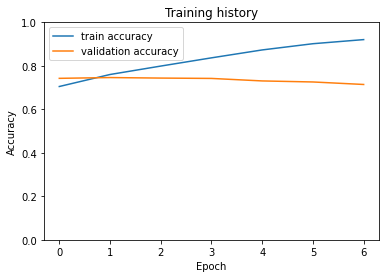

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);


In [ ]:
history

defaultdict(list,
            {'train_acc': [tensor(0.7050, device='cuda:0', dtype=torch.float64),
              tensor(0.7602, device='cuda:0', dtype=torch.float64),
              tensor(0.7990, device='cuda:0', dtype=torch.float64),
              tensor(0.8368, device='cuda:0', dtype=torch.float64),
              tensor(0.8732, device='cuda:0', dtype=torch.float64),
              tensor(0.9018, device='cuda:0', dtype=torch.float64),
              tensor(0.9207, device='cuda:0', dtype=torch.float64)],
             'train_loss': [0.6513527264281854,
              0.543910560908459,
              0.46568376818240365,
              0.38794925088052357,
              0.31109847115236994,
              0.24817956546795064,
              0.20420440174981236],
             'val_acc': [tensor(0.7426, device='cuda:0', dtype=torch.float64),
              tensor(0.7461, device='cuda:0', dtype=torch.float64),
              tensor(0.7437, device='cuda:0', dtype=torch.float64),
              tensor

In [ ]:
model.load_state_dict(torch.load('Roberta_best_model_state.bin'))

<All keys matched successfully>

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.6973298599804625

In [ ]:
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
y_tweet_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.73      0.72      0.72      3972
     neutral       0.74      0.63      0.68      5937
    positive       0.59      0.83      0.69      2375

    accuracy                           0.70     12284
   macro avg       0.69      0.73      0.70     12284
weighted avg       0.71      0.70      0.70     12284



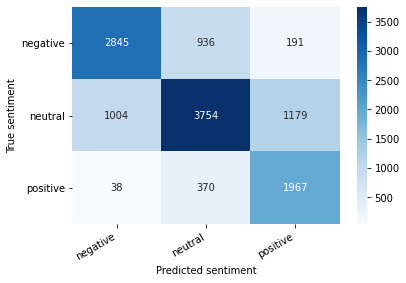

In [ ]:

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
f1_score(y_test, y_pred, average='weighted')

0.697237978165851

In [ ]:
df_test["y_pred"] = y_pred

In [ ]:
df_compare = df_test[df_test['target'] != df_test['y_pred']]

In [ ]:
df_compare.to_csv('roberta_bad_pred.csv', sep="\t")

In [ ]:
f1_score(y_test, y_pred, average=None)

array([0.72401069, 0.68273165, 0.68872549])

In [ ]:
recall_score(y_test, y_pred, average = None)

array([0.71626385, 0.63230588, 0.82821053])

In [ ]:
precision_score(y_test, y_pred, average = None)

array([0.73192694, 0.74189723, 0.5894516 ])

In [ ]:
writeResultsInFile(accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted'), random_seed=RANDOM_SEED)

#SemEval 2020 Task 12

In [ ]:
%cd /content/drive/MyDrive/TER BERTTweet/SemEval2020Task12

In [ ]:
!ls

In [ ]:
df_train = pd.read_csv("task_a_distant.tsv", sep="\t", header=0,  names=['id', 'body', 'target'])
df_test = pd.read_csv("test_a_tweets_all.tsv", sep="\t", header=0,  names=['id', 'body'])
df_ytest = pd.read_csv("test_a_labels_all.csv", sep=",", header=0, names=['id', 'sentiment'])

In [ ]:
df_test = df_test.merge(df_ytest)

In [ ]:
df_train

In [ ]:
df_test

In [ ]:
df_train['target'].unique()

In [ ]:
def sentiment_encode(sentiment):
  if sentiment == 'OFF':
    return 0
  elif sentiment == 'NOT':
    return 1

In [ ]:
df_train['target'] = df_train.target.apply(sentiment_encode)

In [ ]:
df_train, df_val = train_test_split(df_train, test_size=0.1, random_state=RANDOM_SEED)

In [ ]:
token_lens = []
for txt in df_train.body:
  tokens = tokenizer.encode(txt, max_length=128)
  token_lens.append(len(tokens))

In [ ]:
sns.histplot(token_lens)
plt.xlim([0, 128]);
plt.xlabel('Token count');

In [ ]:
MAX_LEN = np.max(token_lens)
BATCH_SIZE = 32

In [ ]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

In [ ]:
data = next(iter(val_data_loader))
data.keys()

In [ ]:
n_classes = 2
class_names = ['offensive', 'not_offensive']

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

In [ ]:
model = SentimentClassifier(n_classes)
model = model.to(device)

In [ ]:
EPOCHS = 30

optimizer = optim.AdamW(model.parameters(), lr=1e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = transformers.get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0
early_stop = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'Roberta_best_model_state.bin')
    best_accuracy = val_acc
    early_stop = 0
  else:
      early_stop = early_stop + 1
      if early_stop == 5:
        break

In [ ]:

model.load_state_dict(torch.load('Roberta_best_model_state.bin'))

In [ ]:
df_test['target'] = df_test.sentiment.apply(sentiment_encode)

In [ ]:
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

In [ ]:
y_tweet_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
f1_score(y_test, y_pred, average='weighted')

In [ ]:
writeResultsInFile(accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted'), random_seed=RANDOM_SEED)